In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error


C:\Users\hwang\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:34: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ._gradient_boosting import predict_stages
C:\Users\hwang\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:34: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ._gradient_boosting import predict_s

In [2]:
%matplotlib inline
plt.rcParams['font.family'] = 'Malgun Gothic'  # (Windows 용) 한글 출력을 위한 글꼴 설정
#plt.rcParams['font.family'] = 'AppleGothic'  # (MAC, 리눅스 용)
plt.rcParams['axes.unicode_minus'] = False    # 문자 - (마이너스) 정상 출력을 위한 코드

pd.options.display.float_format = '{:20,.0f}'.format
pd.options.display.max_columns = 99
np.random.seed(42)

In [3]:
parking = pd.read_csv('실전db.csv', encoding='cp949')

In [4]:
parking = parking.rename(columns=str.lower)

In [5]:
parking.describe()

,user_id,store_id,count
count,"879,271","879,271","879,271"
mean,"1,206,566","149,600",1
std,"420,653","68,898",1
min,224,4,1
25%,"900,576","92,437",1
50%,"1,321,440","173,059",1
75%,"1,542,416","220,661",1
max,"1,830,598","231,465",61


In [6]:
parking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879271 entries, 0 to 879270
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   user_id     879271 non-null  int64 
 1   join_date   879271 non-null  object
 2   d_type      879271 non-null  object
 3   store_id    879271 non-null  int64 
 4   goods_type  879271 non-null  object
 5   date        879271 non-null  object
 6   count       879271 non-null  int64 
 7   ad1         879271 non-null  object
dtypes: int64(3), object(5)
memory usage: 53.7+ MB


In [7]:
parking.head()

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR


<br><br>
## 🚙 Step 1. data 정확히 이해하기

#### ⚠️ categorical 변수들에 대해서는 제대로 설명이 되어 있지 않음

### 📋주어진 Data Description

1. count : 결제 건수
2. join_date : 가입일
3. d_type : 
4. store_id : 점포 주소
5. goods_type :
6. date : 결제일
7. count : 결제건수
8. ad1 : 

🚙 **데이터와 모두의 주차장 앱을 서칭하며 비어있는 data description을 파악해보자**

##### 1. d_type

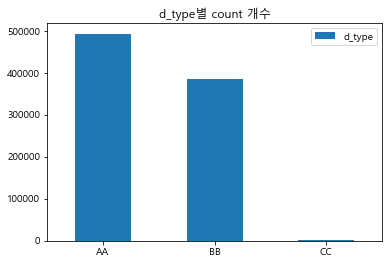

In [8]:
# d_type별 count개수
countbytypes = pd.DataFrame(parking['d_type'].value_counts())
countbytypes.plot(kind = 'bar', title = 'd_type별 count 개수', rot = 0);

In [9]:
parking['d_type'].value_counts()

AA    493166
BB    384541
CC      1564
Name: d_type, dtype: int64

In [10]:
# d_type이 user_id에 1:1 대응되는 모습
parking.groupby('user_id')['d_type'].value_counts()

user_id  d_type
224      AA         2
232      BB        23
342      AA         1
565      AA         2
729      AA         1
                   ..
1830551  BB         1
1830570  BB         1
1830580  AA         1
1830589  BB         1
1830598  AA         1
Name: d_type, Length: 165425, dtype: int64

In [11]:
# d_type이 store_id에 n:m 대응되는 모습
parking.groupby('store_id')['d_type'].value_counts()

store_id  d_type
4         AA        13
          BB        12
8         BB        28
          AA        19
161       BB         3
                    ..
231444    AA         1
231453    AA        14
          BB         8
231465    AA        10
          BB         4
Name: d_type, Length: 2272, dtype: int64

##### 2. goods_type

In [12]:
# goods_type 개수
parking['goods_type'].value_counts()

A    609790
C    131163
B    118541
D     19777
Name: goods_type, dtype: int64

In [13]:
# date별 goods_type의 패턴
parking.groupby(['date', 'goods_type']).size().unstack(fill_value=0).loc['2020-01-01':'2020-01-31',:]

goods_type,A,B,C,D
date,,,,
2020-01-01,661,34,210,19
2020-01-02,921,304,197,56
2020-01-03,905,505,268,46
2020-01-04,1553,144,454,37
2020-01-05,1065,56,351,27
2020-01-06,950,276,192,45
2020-01-07,1021,347,225,33
2020-01-08,997,437,195,33
2020-01-09,988,433,255,42


C:\Users\hwang\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\hwang\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\hwang\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\hwang\Anaconda3\

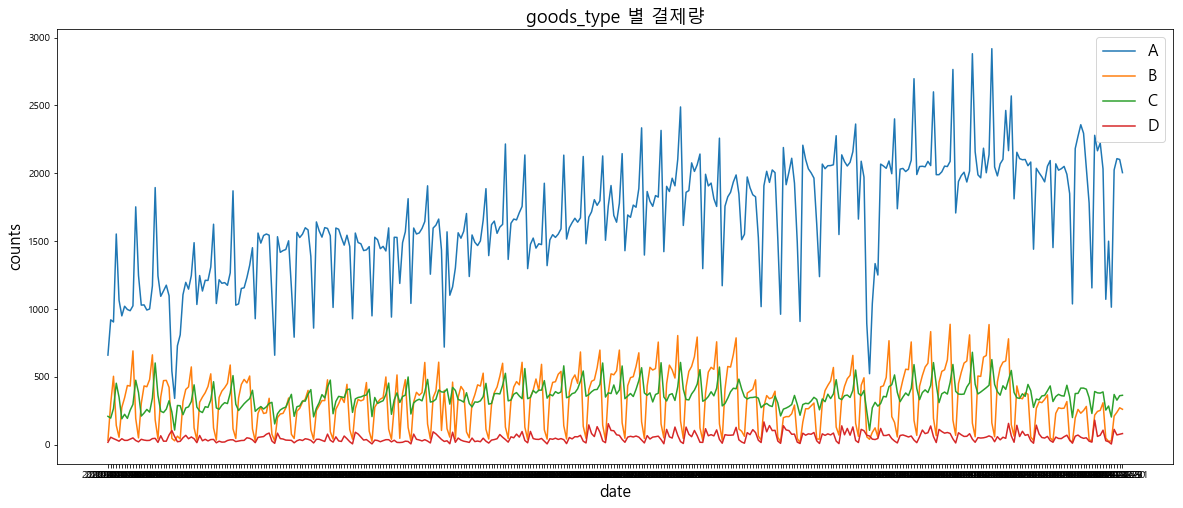

In [14]:
# goods_type 별 결제량 시각화
countbydate = parking.groupby(['date', 'goods_type']).size().unstack(fill_value=0)

plt.figure(figsize=(20,8))
sns.lineplot(countbydate.index, countbydate['A'])
sns.lineplot(countbydate.index, countbydate['B'])
sns.lineplot(countbydate.index, countbydate['C'])
sns.lineplot(countbydate.index, countbydate['D'])

plt.legend(['A', 'B', 'C', 'D'], loc='best', fontsize=16)
plt.title('goods_type 별 결제량', fontsize=18)
plt.ylabel('counts', fontsize=16)
plt.xlabel('date', fontsize=16)
plt.xticks(ticks = None)
plt.show()


##### 3. ad1

In [15]:
parking['ad1'].unique()

array(['GN', 'J', 'SC', 'MP', 'JRR', 'YD', 'GJ', 'YO', 'GSN', 'GBC', 'BF',
       'DJ', '0', 'CD', 'NO', 'CY', 'YC', 'SD', 'GD', 'GSW', 'DM', 'R',
       'GB', 'GS', 'GHN', 'SB', 'IND', 'P', 'GW', 'JR', 'GEJ', 'GGY',
       'GKP', 'CAS', 'SG', 'BJG', 'BHW', 'GAY', 'GYI', 'CCA', 'PJP',
       'GGC', 'IYS', 'DB', 'GGM', 'GAS', 'WOID', 'DIV', 'AOI', 'COI',
       'GPJ', 'SOI', 'ABP', 'DOI', 'WF', 'BI', 'ZP', 'EP', 'Q', 'BO',
       'ZE', 'RRR', 'QGI', 'DSO', 'SOD', 'BOI', 'WT', 'BP', 'SP', 'CN',
       'SJV', 'SDU', 'QH', 'BUD', 'CU', 'VU', 'WAE', 'NW', 'DY', 'WH',
       'GR', 'X', 'CVB', 'ADS', 'VO'], dtype=object)

<br><br>
### 📋 Data description 재정의

|변수명|정의|값|
|:-:|:-:|:-|
|count|결제 건수||
|join_date|가입일||
|d_type|**결제 수단**|AA : 카드 결제<br>BB : 네이버 페이<br>CC : 휴대폰 결제|
|store_id|점포 주소||
|goods_type|**판매 주차권**|A : 모든 종류의 평일 주간 주차권<br>B : 모든 종류의 평일 야간 주차권<br>C : 모든 종류의 주말 주간 주차권<br>D : 모든 종류의 주말 야간 주차권|
|date|결제일||
|count|결제 건수||
|ad1|**지역 코드**|예) GN : 강남, MP : 마포 ...|

<br>

* goods_type 세분화

|goods_type|주간|야간|
|---|---|---|
|평일|A|B|
|주말|C|D|

* 지역 코드 ad1의 경우, 함께 주어진 외부 데이터가 서울시 중심이라 서울 지역을 세분화한 코드라고 예측.

❗️ **한편 회의를 통해 가장 가능성이 높은 설명을 붙였으며, 정의를 단정짓기는 어려움**


<br><br>
## 🚫 Step 2. 결측치, 이상치 확인

+ 결측치 : 없음
+ 이상치 : 
 - join_date == 1970-01-01 데이터는 치환 없이 삭제하기로 결정 (5.10 회의)
 - user_id == 999665 데이터는 비상식적인 결제량 정보를 담고 있으므로 제거 (찬서님 의견 + 코드)

In [16]:
# Unix time error
parking[(parking['join_date'] == '1970-01-01')].sort_values(by = 'count', ascending = False)

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1
368711,1277650,1970-01-01,CC,92264,C,2020-06-26,4,JRR
269797,851134,1970-01-01,CC,190482,A,2020-05-17,3,GN
71522,1493307,1970-01-01,CC,82433,D,2020-02-10,3,CY
590435,1661920,1970-01-01,CC,109877,C,2020-09-18,2,GN
139409,654237,1970-01-01,CC,181777,C,2020-03-17,2,BF
...,...,...,...,...,...,...,...,...
175767,654237,1970-01-01,CC,181777,C,2020-04-03,1,BF
176320,1071641,1970-01-01,CC,221045,A,2020-04-03,1,GN
176853,1355917,1970-01-01,CC,220700,A,2020-04-03,1,GN
176971,1415023,1970-01-01,CC,131081,A,2020-04-03,1,YO


In [17]:
parking[(parking['user_id'] == 999665)].sort_values(by = 'count', ascending = False).head(10)

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1
729776,999665,2018-12-16,CC,96266,A,2020-11-07,61,GN
748372,999665,2018-12-16,CC,109677,A,2020-11-13,59,JRR
751974,999665,2018-12-16,CC,1109,A,2020-11-14,58,JRR
726277,999665,2018-12-16,CC,190055,A,2020-11-06,55,SB
767392,999665,2018-12-16,CC,131081,A,2020-11-19,53,YO
687010,999665,2018-12-16,CC,182320,A,2020-10-24,51,JRR
690265,999665,2018-12-16,CC,222401,A,2020-10-25,50,CY
708664,999665,2018-12-16,CC,104067,A,2020-10-31,50,MP
764097,999665,2018-12-16,CC,220607,A,2020-11-18,49,GN
705100,999665,2018-12-16,CC,1900,C,2020-10-30,49,GN


In [18]:
parking = parking[~(parking['join_date']=='1970-01-01')]
parking = parking[parking['user_id'] != 999665]

<br><br><br>
## 🔧Step 3. Feature Engineering 진행

- 1. 외부데이터인 '서울시_기상데이터.csv'를 이용하여 count와 관계가 있을 만한 변수를 가져온다.
- 2. 주어진 데이터의 기본 변수에서 새로운 컬럼을 추가한다.


#### ✅Feature Engineering 을 진행하기 전 먼저 train과 test 데이터를 분류해준다.

In [19]:
# train, test
train = parking[parking.date <= '2020-09-30']
test = parking[parking.date > '2020-09-30']
display(train, test)

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR
...,...,...,...,...,...,...,...,...
623574,1709914,2020-09-30,BB,221022,B,2020-09-30,1,GN
623575,1709935,2020-09-30,AA,725,B,2020-09-30,1,MP
623576,1709942,2020-09-30,AA,223058,B,2020-09-30,1,BF
623577,1709950,2020-09-30,BB,182320,A,2020-09-30,2,JRR


,user_id,join_date,d_type,store_id,goods_type,date,count,ad1
623579,15521,2014-09-12,AA,182320,A,2020-10-01,1,JRR
623580,17651,2014-09-19,BB,82434,D,2020-10-01,1,J
623581,26388,2014-10-25,BB,182320,A,2020-10-01,1,JRR
623582,81772,2015-05-02,BB,204438,A,2020-10-01,1,DJ
623583,92258,2015-05-24,AA,220745,A,2020-10-01,1,SD
...,...,...,...,...,...,...,...,...
879266,1830551,2020-12-31,BB,219886,B,2020-12-31,1,GN
879267,1830570,2020-12-31,BB,82433,B,2020-12-31,1,CY
879268,1830580,2020-12-31,AA,92020,B,2020-12-31,1,JRR
879269,1830589,2020-12-31,BB,92437,B,2020-12-31,1,J


#### 1. 외부 데이터 Feature Engineering

In [20]:
weather_data = pd.read_csv('서울시_기상데이터.csv', encoding='cp949')
weather_data.dtypes

지점        int64
일시       object
기온      float64
강수량     float64
풍속      float64
습도        int64
일조시간    float64
적설량     float64
지면온도    float64
지중온도    float64
dtype: object

In [21]:
weather_data['일시'] = weather_data['일시'].astype('datetime64')
weather_data['date'] = weather_data['일시'].dt.date
weather_data['기온'] = weather_data['기온'].fillna(30)
weather_data = weather_data.fillna(0)
display(weather_data, weather_data.isna().sum())

,지점,일시,기온,강수량,풍속,습도,일조시간,적설량,지면온도,지중온도,date
0,108,2020-01-01 01:00:00,-6,0,2,40,0,0,-2,3,2020-01-01
1,108,2020-01-01 02:00:00,-6,0,0,42,0,0,-2,3,2020-01-01
2,108,2020-01-01 03:00:00,-6,0,0,46,0,0,-3,3,2020-01-01
3,108,2020-01-01 04:00:00,-5,0,0,50,0,0,-2,3,2020-01-01
4,108,2020-01-01 05:00:00,-5,0,0,55,0,0,-2,3,2020-01-01
...,...,...,...,...,...,...,...,...,...,...,...
8755,108,2020-12-30 20:00:00,-12,0,5,54,0,0,-6,2,2020-12-30
8756,108,2020-12-30 21:00:00,-12,0,3,58,0,0,-7,2,2020-12-30
8757,108,2020-12-30 22:00:00,-13,0,3,56,0,0,-7,2,2020-12-30
8758,108,2020-12-30 23:00:00,-13,0,2,54,0,0,-7,2,2020-12-30


지점      0
일시      0
기온      0
강수량     0
풍속      0
습도      0
일조시간    0
적설량     0
지면온도    0
지중온도    0
date    0
dtype: int64

In [22]:
# 일교차 정보를 가지고 있는 Tdata 생성
Tdata = pd.DataFrame(weather_data.groupby('date')['기온'].agg(np.ptp)).reset_index()
Tdata = Tdata.rename(columns = {'기온': 'temp_diff'}, inplace = False)
Tdata.loc[365, 'temp_diff'] = 7.9
Tdata

,date,temp_diff
0,2020-01-01,6
1,2020-01-02,4
2,2020-01-03,8
3,2020-01-04,9
4,2020-01-05,10
...,...,...
361,2020-12-27,8
362,2020-12-28,7
363,2020-12-29,10
364,2020-12-30,7


In [23]:
weather_mean = weather_data.groupby('date').mean()

In [24]:
# 평균 기온과 날씨 변수 생성
# 강수량은 '눈 또는 비'를 의미하므로, 강수량과 적설량이 동시에 나타나야 눈이 온 것으로 확인할 수 있다.
weather_mean['weather'] = np.where(weather_mean["강수량"].values >= 0.1 , "rain", np.where(weather_mean['적설량'].values > 0, 'snow', 'none'))
weather_mean = weather_mean.rename(columns = {'기온': 'mean_temp'}, inplace = False)

In [25]:
weather_mean['weather'].value_counts()

none    294
rain     62
snow     10
Name: weather, dtype: int64

In [26]:
# 강수량 데이터를 보면 2월 16일부터 18일까지 비가 왔는데 16일에 적설량은 0이다.
# 따라서 16일 날씨는 비, 17, 18일은 눈이 왔다고 예측할 수 있는데, weather에 예측한대로 데이터가 들어갔는지 확인
weather_mean.iloc[40:50,:]

,지점,mean_temp,강수량,풍속,습도,일조시간,적설량,지면온도,지중온도,weather
date,,,,,,,,,,
2020-02-10,108,4,0,2,51,0,0,3,3,none
2020-02-11,108,6,0,2,39,0,0,3,3,none
2020-02-12,108,7,0,2,69,0,0,6,4,rain
2020-02-13,108,7,0,2,85,0,0,7,5,none
2020-02-14,108,8,0,1,71,0,0,7,6,none
2020-02-15,108,10,0,3,62,0,0,7,6,none
2020-02-16,108,-1,1,4,83,0,2,2,6,rain
2020-02-17,108,-6,0,3,67,0,3,0,5,snow
2020-02-18,108,-4,0,2,44,0,1,-0,4,snow


In [27]:
weather_mean = weather_mean.rename_axis('date').reset_index()

In [28]:
weather_data2 = pd.merge(Tdata, weather_mean[['date', 'weather', 'mean_temp']], how = 'left', on = 'date')

In [29]:
weather_data2.loc[365, 'mean_temp'] = -8.9
weather_data2

,date,temp_diff,weather,mean_temp
0,2020-01-01,6,none,-3
1,2020-01-02,4,none,1
2,2020-01-03,8,none,0
3,2020-01-04,9,none,1
4,2020-01-05,10,none,1
...,...,...,...,...
361,2020-12-27,8,none,5
362,2020-12-28,7,none,7
363,2020-12-29,10,none,1
364,2020-12-30,7,none,-10


In [30]:
parking['date'] = parking['date'].astype('datetime64')
weather_data2['date'] = weather_data2['date'].astype('datetime64')
parking = pd.merge(parking, weather_data2, how = 'left', on = 'date')

#### 2. 기본 변수에 대한 Feature Engineering

In [31]:
# 기본 날짜 데이터 쪼개기
parking['year'] = parking['date'].dt.year
parking['month'] = parking['date'].dt.month
parking['day'] = parking['date'].dt.day
parking['weekday'] = parking['date'].dt.weekday
parking['week'] = parking['date'].dt.isocalendar().week

# 공휴일 추가
parking['isholiday'] = parking['date'].isin(['2020-01-01', '2020-01-24', '2020-01-25', '2020-01-26', '2020-03-01', '2020-04-30', '2020-05-05', '2020-06-06', '2020-08-15', '2020-08-17', '2020-09-30', '2020-10-01', '2020-10-02', '2020-10-03', '2020-10-09', '2020-12-25'])

# 몇개월차 유저인가
parking['join_date'] = parking['join_date'].astype('datetime64')
parking['howlonguser'] = (parking['year']*12 + parking['month']) - (parking['join_date'].dt.year*12 + parking['join_date'].dt.month) + 1

In [32]:
# 누적 결제 횟수
df_l = parking.sort_values(['user_id','date']).reset_index(drop=True)
df_l['next'] = df_l.sort_values(['user_id','date']).groupby('user_id')['date'].shift(-1)
df_l['before'] = df_l.sort_values(['user_id','date']).groupby('user_id')['date'].shift(1)
df_l['freq_cum'] = pd.DataFrame(df_l.groupby(['user_id','date'])['before'].count()).groupby('user_id')['before'].cumsum().values
parking = df_l
parking = parking.drop(['next', 'before'], 1)

In [33]:
# freq_cum의 통계를 가지고 등급 매기기
parking['freq_cum'].describe()

count                877,812
mean                      15
std                       24
min                        0
25%                        1
50%                        5
75%                       18
max                      243
Name: freq_cum, dtype: float64

In [34]:
parking['freq_cum'].value_counts()

0      165160
1       90428
2       63790
3       49380
4       40199
        ...  
242         1
237         1
236         1
235         1
243         1
Name: freq_cum, Length: 244, dtype: int64

In [35]:
parking['ranking'] = np.where(parking["freq_cum"].values <= 1 , '브론즈', np.where(parking["freq_cum"].values <= 5 , '실버', np.where(parking["freq_cum"].values <= 18 , '골드', '플레티넘')))

In [36]:
parking.head(20)

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1,temp_diff,weather,mean_temp,year,month,day,weekday,week,isholiday,howlonguser,freq_cum,ranking
0,224,2013-12-16,AA,92510,A,2020-01-12,1,J,6,none,-1,2020,1,12,6,2,False,74,0,브론즈
1,224,2013-12-16,AA,181833,C,2020-12-09,1,J,10,none,1,2020,12,9,2,50,False,85,1,브론즈
2,232,2013-12-17,BB,109555,C,2020-01-19,1,GJ,5,snow,2,2020,1,19,6,3,False,74,0,브론즈
3,232,2013-12-17,BB,28018,C,2020-01-26,1,JRR,12,none,5,2020,1,26,6,4,True,74,1,브론즈
4,232,2013-12-17,BB,28018,C,2020-01-27,1,JRR,2,none,6,2020,1,27,0,5,False,74,2,실버
5,232,2013-12-17,BB,131081,A,2020-01-29,1,YO,6,none,6,2020,1,29,2,5,False,74,3,실버
6,232,2013-12-17,BB,28018,C,2020-02-09,1,JRR,9,none,-1,2020,2,9,6,6,False,75,4,실버
7,232,2013-12-17,BB,173268,A,2020-02-20,1,J,11,none,4,2020,2,20,3,8,False,75,5,실버
8,232,2013-12-17,BB,28018,C,2020-03-01,1,JRR,7,none,6,2020,3,1,6,9,True,76,6,골드
9,232,2013-12-17,BB,220655,A,2020-03-29,1,JRR,14,none,9,2020,3,29,6,13,False,76,7,골드


<br><br>
#### 🔧Feature Engineering 내용 정리

1. 주어진 서울시 기상데이터 csv 파일로 `weather`, `mean_temp`, `temp_diff` 변수를 추가했다.
 - weather : 날씨 ('눈', '비', '해당없음')
 - mean_temp : 평균 온도
 - temp_diff : 일교차 (일 최고기온 - 최저기온)
<br> 주어진 데이터에서 기온 값에 하나의 NA값이 존재하는데, max나 min에 영향을 받지 않을 정도의 숫자 30을 임의로 집어넣었다.
<br>또한 12월 31일 날짜에는 00시 데이터만 있다. 12월 31 날짜의 평균 온도와 일교차는 아래 링크를 참고하여 데이터를 삽입했다.<br>  https://www.weather.go.kr/weather/climate/past_cal.jsp?stn=108&yy=2020&mm=12&x=20&y=5&obs=1
<br><br>
2. date 변수를 연, 월, 일자, 날짜, 주차로 쪼개서 저장하여 각각 `year`, `month`, `day`, `weekday`, `week`의 변수를 추가했다.
<br><br>
3. (결제년월 - 가입년월)로 몇 개월차 유저인지 파악하는 변수 `howlonguser`를 만들었다.
<br><br>
4. 국가 공휴일 데이터인 `isholiday` 변수를 추가했다. 다음의 사이트를 참고하였다.<br>
https://publicholidays.co.kr/ko/2020-dates/
<br><br>
5. 누적 결제를 카운트하는 `freq_cum`을 만들고 `freq_cum`의 통계량을 바탕으로 회원 등급을 매기는 `ranking` 컬럼을 만들었다. (지인님 코드)

## 🚙 Step 4. EDA

#### 1. count

In [37]:
# count
parking['count'].value_counts()

1     862704
2      13500
3       1058
4        270
5        133
6         63
7         36
9         12
8         11
10         6
15         4
11         3
12         3
13         3
23         2
22         1
17         1
19         1
20         1
Name: count, dtype: int64

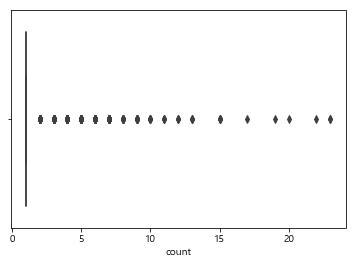

In [38]:
# count == 1이 아니면 전부 이상치로 판단하는 모습
sns.boxplot(x = "count",
            data = parking)
plt.show()

C:\Users\hwang\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\hwang\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\hwang\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\hwang\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Suppor

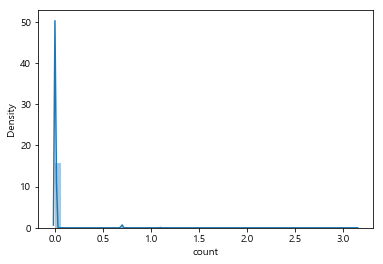

In [39]:
# count 빈도 log
sns.distplot(np.log(parking['count']));

C:\Users\hwang\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\hwang\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\hwang\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\hwang\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Suppor

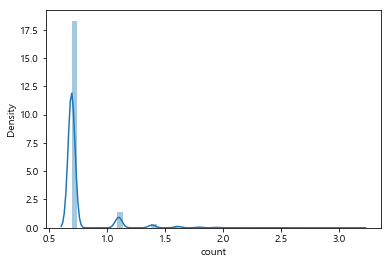

In [40]:
# count != 1 빈도
withoutcount1 = parking.drop(parking[parking['count'] == 1].index)
sns.distplot(np.log(withoutcount1['count']));

#### 2. corrplot

상관 분석을 위해 corrplot을 그려본다.

이 때, count == 1의 값이 

##### 1) count == 1 포함 corrplot

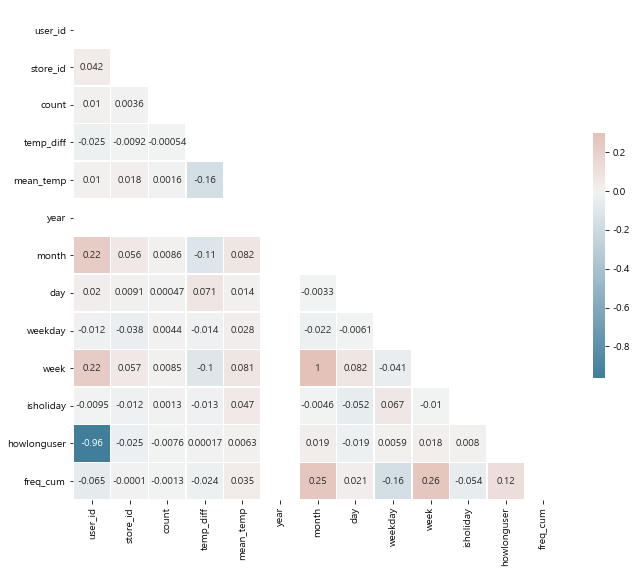

In [41]:
corr = parking.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.show()

##### 2) count != 1 데이터의 corrplot

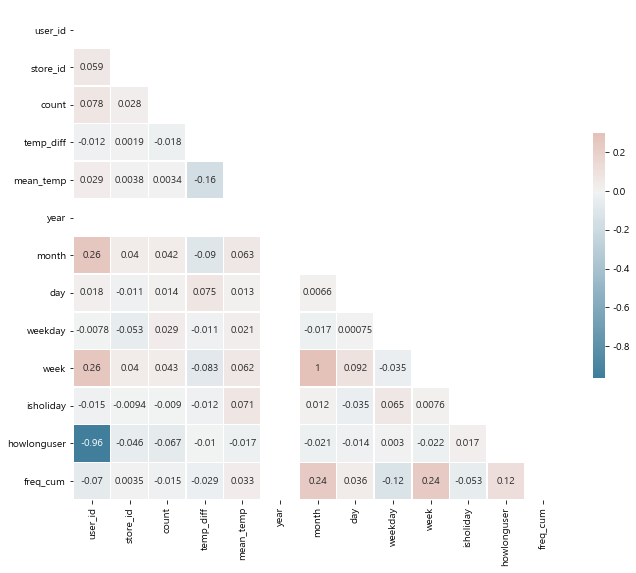

In [42]:
no_one = parking[parking['count'] != 1]

corr = no_one.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.show()

#### corrplot 결과

0. 데이터가 갖는 편향성(count == 1이 압도적) 때문에 corrplot으로 count와 다른 feature들과의 상관관계를 정확히 파악하기 힘듬
1. count가 1인 경우를 제외하면서 corrplot을 살펴보았을 때도 마찬가지임
2. 2020년 결제 데이터라 `year` 변수는 모델링 관점에서는 의미가 없음
3. `week`와 `month`의 상관계수가 1이기 때문에 모델링 시 하나의 변수는 제거 가능
3. `howlonguser`와 `user_id`의 상관계수가 -1에 가깝기 때문에 모델링 시 하나의 변수는 제거 가능

##### 3. Features

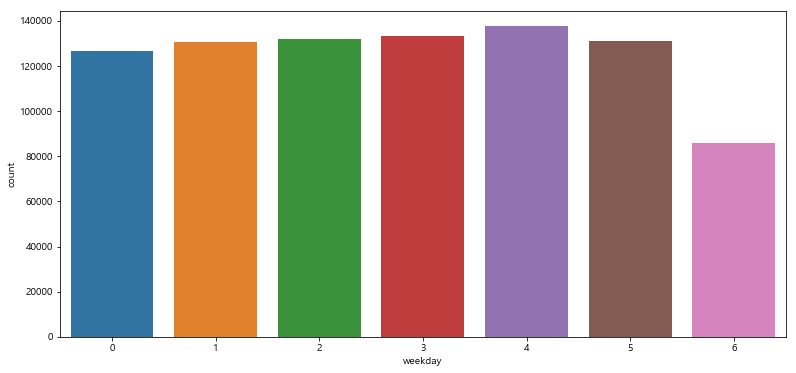

In [43]:
# 요일별 사용량 차트
plt.figure(figsize=(13,6))
sns.countplot(data = parking, x = 'weekday');

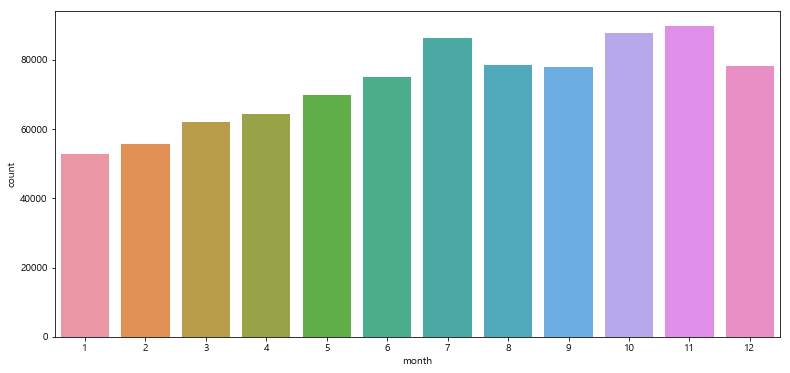

In [44]:
# 월별 사용량 차트
plt.figure(figsize=(13,6))
sns.countplot(data = parking, x = 'month');

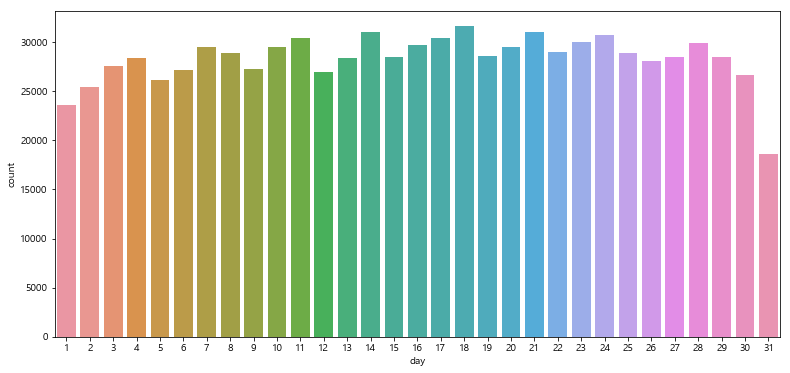

In [45]:
# 일자별 사용량
plt.figure(figsize=(13,6))
sns.countplot(data = parking, x = 'day');

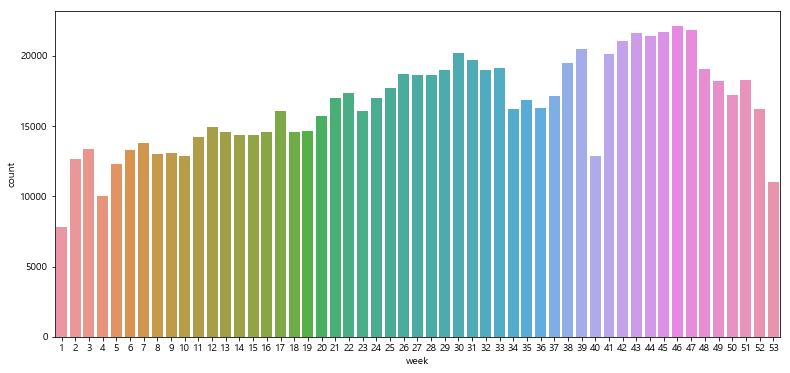

In [46]:
# 주차(week)별 사용량
plt.figure(figsize=(13,6))
sns.countplot(data = parking, x = 'week');

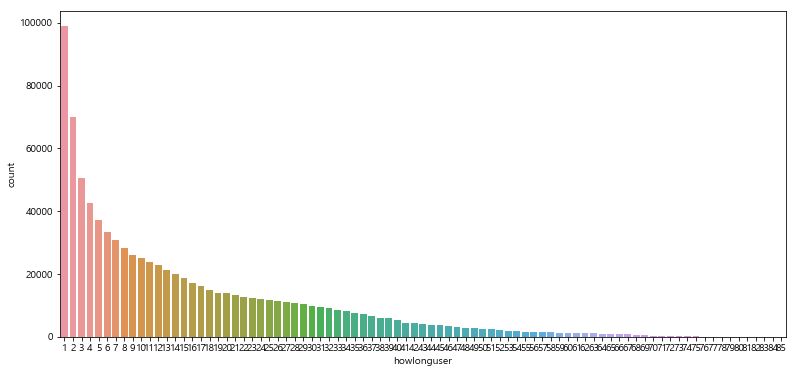

In [47]:
# 유저 가입 기간별 결제량
plt.figure(figsize=(13,6))
sns.countplot(data = parking, x = 'howlonguser');

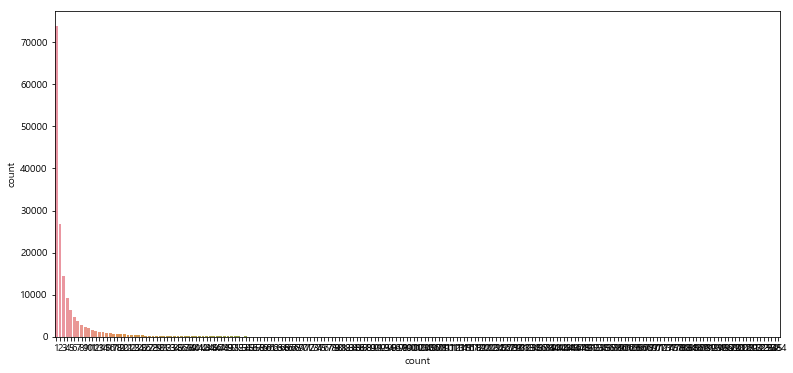

In [48]:
# 유저 id 당 count 횟수 : 약 16만명 회원 중 7만 3천명 정도가 한번만 사용
plt.figure(figsize=(13,6))
df_user = parking.groupby('user_id')['count'].sum().reset_index().sort_values(by = 'count', ascending = False)
sns.countplot(data = df_user, x = 'count');

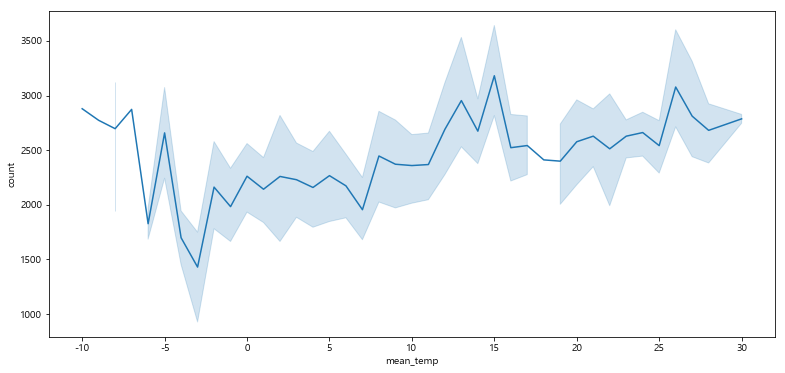

In [49]:
# 평균 온도에 따른 이용량 추이 (평균 온도의 소수점 첫째자리에서 반올림)
plt.figure(figsize=(13,6))
df_m_temp = parking.groupby('mean_temp')['count'].sum().reset_index()
df_m_temp['mean_temp'] = round(df_m_temp['mean_temp'])
sns.lineplot(data = df_m_temp, x = 'mean_temp', y = 'count');

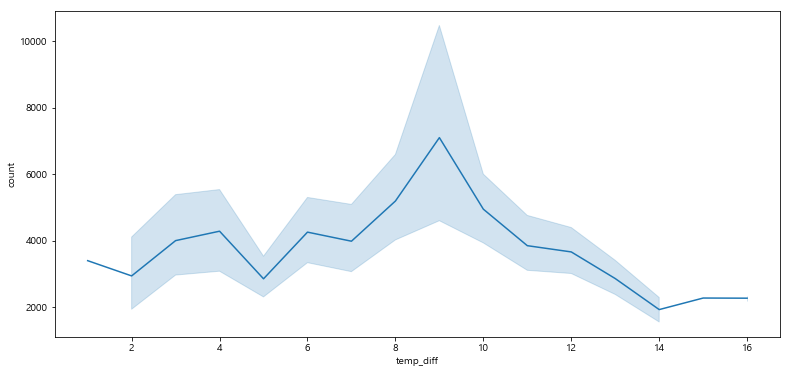

In [50]:
# 일교차에 따른 이용량 추이 (일교차의 소수점 첫째자리에서 반올림)
plt.figure(figsize=(13,6))
df_m_temp = parking.groupby('temp_diff')['count'].sum().reset_index()
df_m_temp['temp_diff'] = round(df_m_temp['temp_diff'])
sns.lineplot(data = df_m_temp, x = 'temp_diff', y = 'count');

### 🚙 EDA 내용 정리

1. 
count == 1 값이 압도적임. 이러한편향 문제를 해결하기 위해서 생각해볼 수 있는 방법

smote 기법 : count != 1의 값들을 count == 1의 개수에 맞게 증대시키는 방법

현실적으로 불가능!

## ⚙️ Step 5. label encoding과 Random Forest Regressor

0. label encoding 전 train, test 데이터 확인. 전체 데이터(parking)의 결측치 재확인
1. 전체 데이터를 가공용 데이터(alldata)로 만들어서 코드 진행. 
2. 문자열 변수의 경우 전체 label encoding 진행
3. alldata를 train, test 데이터의 차원에 맞게 쪼개기
4. 불필요한 변수 제거
5. 예측
6. 예측 평가 MSE, MAE

In [51]:
display(train, test, parking)

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR
...,...,...,...,...,...,...,...,...
623574,1709914,2020-09-30,BB,221022,B,2020-09-30,1,GN
623575,1709935,2020-09-30,AA,725,B,2020-09-30,1,MP
623576,1709942,2020-09-30,AA,223058,B,2020-09-30,1,BF
623577,1709950,2020-09-30,BB,182320,A,2020-09-30,2,JRR


,user_id,join_date,d_type,store_id,goods_type,date,count,ad1
623579,15521,2014-09-12,AA,182320,A,2020-10-01,1,JRR
623580,17651,2014-09-19,BB,82434,D,2020-10-01,1,J
623581,26388,2014-10-25,BB,182320,A,2020-10-01,1,JRR
623582,81772,2015-05-02,BB,204438,A,2020-10-01,1,DJ
623583,92258,2015-05-24,AA,220745,A,2020-10-01,1,SD
...,...,...,...,...,...,...,...,...
879266,1830551,2020-12-31,BB,219886,B,2020-12-31,1,GN
879267,1830570,2020-12-31,BB,82433,B,2020-12-31,1,CY
879268,1830580,2020-12-31,AA,92020,B,2020-12-31,1,JRR
879269,1830589,2020-12-31,BB,92437,B,2020-12-31,1,J


,user_id,join_date,d_type,store_id,goods_type,date,count,ad1,temp_diff,weather,mean_temp,year,month,day,weekday,week,isholiday,howlonguser,freq_cum,ranking
0,224,2013-12-16,AA,92510,A,2020-01-12,1,J,6,none,-1,2020,1,12,6,2,False,74,0,브론즈
1,224,2013-12-16,AA,181833,C,2020-12-09,1,J,10,none,1,2020,12,9,2,50,False,85,1,브론즈
2,232,2013-12-17,BB,109555,C,2020-01-19,1,GJ,5,snow,2,2020,1,19,6,3,False,74,0,브론즈
3,232,2013-12-17,BB,28018,C,2020-01-26,1,JRR,12,none,5,2020,1,26,6,4,True,74,1,브론즈
4,232,2013-12-17,BB,28018,C,2020-01-27,1,JRR,2,none,6,2020,1,27,0,5,False,74,2,실버
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
877807,1830551,2020-12-31,BB,219886,B,2020-12-31,1,GN,8,none,-9,2020,12,31,3,53,False,1,0,브론즈
877808,1830570,2020-12-31,BB,82433,B,2020-12-31,1,CY,8,none,-9,2020,12,31,3,53,False,1,0,브론즈
877809,1830580,2020-12-31,AA,92020,B,2020-12-31,1,JRR,8,none,-9,2020,12,31,3,53,False,1,0,브론즈
877810,1830589,2020-12-31,BB,92437,B,2020-12-31,1,J,8,none,-9,2020,12,31,3,53,False,1,0,브론즈


In [52]:
parking.dtypes

user_id                 int64
join_date      datetime64[ns]
d_type                 object
store_id                int64
goods_type             object
date           datetime64[ns]
count                   int64
ad1                    object
temp_diff             float64
weather                object
mean_temp             float64
year                    int64
month                   int64
day                     int64
weekday                 int64
week                   UInt32
isholiday                bool
howlonguser             int64
freq_cum                int64
ranking                object
dtype: object

In [53]:
parking.isna().sum()

user_id        0
join_date      0
d_type         0
store_id       0
goods_type     0
date           0
count          0
ad1            0
temp_diff      0
weather        0
mean_temp      0
year           0
month          0
day            0
weekday        0
week           0
isholiday      0
howlonguser    0
freq_cum       0
ranking        0
dtype: int64

In [54]:
alldata = parking

In [55]:
le = LabelEncoder()

cat_cols = alldata.columns[alldata.dtypes == object]
for i in cat_cols:
    alldata[i] = le.fit_transform(alldata[i])

In [56]:
alldata

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1,temp_diff,weather,mean_temp,year,month,day,weekday,week,isholiday,howlonguser,freq_cum,ranking
0,224,2013-12-16,0,92510,0,2020-01-12,1,49,6,0,-1,2020,1,12,6,2,False,74,0,1
1,224,2013-12-16,0,181833,2,2020-12-09,1,49,10,0,1,2020,12,9,2,50,False,85,1,1
2,232,2013-12-17,1,109555,2,2020-01-19,1,37,5,2,2,2020,1,19,6,3,False,74,0,1
3,232,2013-12-17,1,28018,2,2020-01-26,1,51,12,0,5,2020,1,26,6,4,True,74,1,1
4,232,2013-12-17,1,28018,2,2020-01-27,1,51,2,0,6,2020,1,27,0,5,False,74,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
877807,1830551,2020-12-31,1,219886,1,2020-12-31,1,39,8,0,-9,2020,12,31,3,53,False,1,0,1
877808,1830570,2020-12-31,1,82433,1,2020-12-31,1,19,8,0,-9,2020,12,31,3,53,False,1,0,1
877809,1830580,2020-12-31,0,92020,1,2020-12-31,1,51,8,0,-9,2020,12,31,3,53,False,1,0,1
877810,1830589,2020-12-31,1,92437,1,2020-12-31,1,49,8,0,-9,2020,12,31,3,53,False,1,0,1


In [57]:
# drop columns
# train, test
train2 = alldata[alldata.date <= '2020-09-30']
test2 = alldata[alldata.date > '2020-09-30']

# week를 드랍하는 이유는 우리나라 명절 중 설날, 추석은 음력으로 계산하기 때문에 매년 week값이 바뀌기 때문이다.
train3 = train2.drop(['join_date', 'date', 'year', 'week'], 1)
test3 = test2.drop(['join_date', 'date', 'year', 'week'], 1)

In [58]:
rf = RandomForestRegressor()

In [59]:
%%time
rf.fit(train3, train['count'])
result = rf.predict(test3)
result

C:\Users\hwang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\hwang\Anaconda3\lib\site-packages\sklearn\ensemble\base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


Wall time: 1min 9s


In [60]:
MSE = mean_squared_error(result, test['count'])
MAE = mean_absolute_error(result, test['count'])

In [61]:
print('MSE : ', MSE, '\nMAE : ', MAE)

MSE :  0.09418997256134556 
MAE :  0.16383107809252426


In [62]:
unique, counts = np.unique(result, return_counts=True)
dict(zip(unique, counts))

{1.0: 110017,
 1.1: 55825,
 1.2: 39785,
 1.3: 10733,
 1.4: 10724,
 1.5: 19570,
 1.6: 3098,
 1.7: 3738,
 1.8: 531,
 1.9: 758,
 2.0: 158,
 2.1: 183,
 2.2: 57,
 2.3: 29,
 2.4: 18,
 2.5: 16,
 2.6: 3,
 2.7: 6,
 2.8: 58,
 2.9: 67,
 3.0: 9,
 3.1: 15,
 3.2: 44,
 3.3: 11,
 3.4: 6,
 3.5: 2,
 3.6: 5,
 3.7: 1,
 3.8: 2,
 3.9: 1,
 5.4: 3,
 5.5: 1,
 5.6: 1,
 7.6: 4}

In [63]:
# 앞으로 수행되어야 하는 부분
# FE 마무리 (교통량, 불쾌지수, howlonguser 연장)
# EDA 심화
# ML drop 확인